Data Wrangling
----

# Outline

# Setup

In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime
from os import getcwd
import json
import gzip
print("Working directory: ", getcwd())

Working directory:  /home/mark/coding/QualAbstracts/notebooks


# Filtering for Social Science and Humanities Articles

## Links to APIs
- Finding registration authority: https://www.doi.org/the-identifier/resources/factsheets/doi-resolution-documentation#4-which-ra
    - Note, vast majority of academic articles are on crossref
- Crossref lookup by doi: https://api.crossref.org/swagger-ui/index.html#/Works/get_works__doi_
    - Note preference for including email
    - Or download 185GB as torrent: https://www.crossref.org/blog/2023-public-data-file-now-available-with-new-and-improved-retrieval-options/
- DataCite: https://support.datacite.org/docs/api-get-doi 

## CORE metadata

In [4]:
articles_md = pd.read_csv('../data/all_articles_notext.csv.gz')
print(articles_md.info())
articles_md.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650037 entries, 0 to 1650036
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   doi       1650036 non-null  object
 1   title     1650033 non-null  object
 2   abstract  1649014 non-null  object
 3   issn      1548098 non-null  object
 4   subjects  686568 non-null   object
dtypes: object(5)
memory usage: 62.9+ MB
None


,doi,title,abstract,issn,subjects
0,10.1111/1467-8330.00227,Institutionalising future geographies of finan...,This paper provides a critical overview of rec...,'0066-4812',NaN
1,10.1163/13822373-90002428,Landscaping Hispaniola Moreau de Saint-Méry's ...,This article focuses on Médéric Louis Élie Mor...,"'issn:1382-2373', '1382-2373'",NaN
2,10.3354/meps09193,Modelling the effect of vertical mixing on bot...,Reliable estimates of in situ phytoplankton gr...,"'1616-1599', 'issn:0171-8630', 'issn:1616-1599...",NaN
3,10.1177/1350508408095817,The Body Dances: Carnival Dance and Organization,Building on the work of Pierre Bourdieu and Ma...,'1350-5084',sociology
4,10.1016/s0022-4049(02)00180-9,Arithmeticity of Orbifold Generalised Triangle...,Maclachlan and Martin have proved that only fi...,'0022-4049',NaN


In [26]:
# records without DOIs are useless
articles_md.dropna(subset=['doi'], inplace=True)
# remove duplicated DOIs
articles_md.drop_duplicates(subset=['doi'], inplace=True)
articles_md.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1639120 entries, 0 to 1650035
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   doi       1639120 non-null  object
 1   title     1639116 non-null  object
 2   abstract  1638100 non-null  object
 3   issn      1537955 non-null  object
 4   subjects  683181 non-null   object
dtypes: object(5)
memory usage: 75.0+ MB


In [10]:
articles_md.subjects.value_counts()

subjects
biology                  147912
medicine                 128554
physics                  122715
mathematics               51452
computer science          45695
chemistry                 45396
psychology                26838
engineering               25290
materials science         19515
geology                   15122
economics                 13877
sociology                 13610
history                    6453
art                        5260
geography                  4413
business                   3097
political science          2942
philosophy                 2607
environmental science      2433
Name: count, dtype: int64

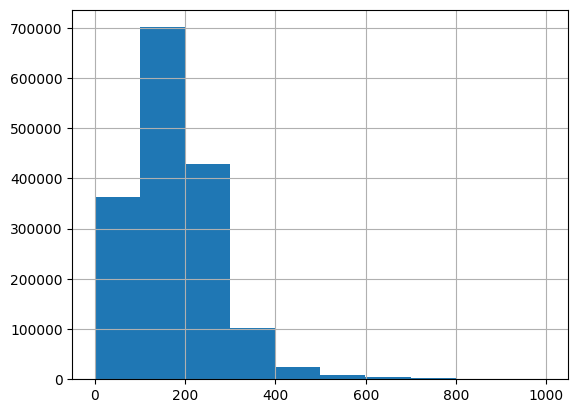

In [23]:
def word_count(s):
    return len(s.split()) if type(s) == str else np.NaN

abstract_wordcounts = articles_md.abstract.apply(word_count)
abstract_wordcounts[abstract_wordcounts < 1000].hist();

In [27]:
abstract_wordcounts.describe()

count    1.638100e+06
mean     1.766889e+02
std      1.143214e+02
min      0.000000e+00
25%      1.060000e+02
50%      1.620000e+02
75%      2.300000e+02
max      3.714000e+03
Name: abstract, dtype: float64

In [48]:
articles_md['abstract_word_count'] = abstract_wordcounts
print(articles_md.sort_values('abstract_word_count').abstract.dropna().iloc[-1])

Lorsque la Fédération des travailleurs de l'Ontario avait décidé d’étudier le problème de la crise constitutionnelle que traverse le Canada, elle avait souhaité entendre le point de vue, sinon du Québec, du moins d'un travailleur syndiqué du Québec.Far be it from me to minimize the initiative you have taken, but I cannot help telling you, without making the Ontario Federation of Labour a specific target, that Labour allowed itself to wait far too long. For, ever since the Quebec Federation of Labour, at the very outset of the work by the Laurendeau-Dunton Commission on Bilingualism and Biculturalism, asked this body to organize conferences between trade unionists throughout the country, we have continued to await such an invitation from an organisation such as yours. Following up on the efforts of the Montreal Labour Council, the QFL also called upon the Canadian Labour Congress to organize such a meeting.If we attach so much importance to such meetings of unionized workers outside of 

## Registration authority

In [3]:
doi_ra = pd.read_csv('../data/doi_ra.csv').drop_duplicates(subset='doi').dropna()
doi_ra = doi_ra[doi_ra.ra =='Crossref']
print(doi_ra.describe())

                            doi        ra
count                   1598295   1598295
unique                  1598295         1
top     10.1111/1467-8330.00227  Crossref
freq                          1   1598295


## Crossref data

### Inspecting the raw data

In [2]:
with gzip.open('../data/crossref_data_2023_04/0.json.gz') as f:
    cr_json0 = json.load(f)
cr_json0.keys()

dict_keys(['items'])

In [7]:
cr_list0 = cr_json0['items']
cr_list0[2].keys()

dict_keys(['abstract', 'URL', 'resource', 'member', 'score', 'created', 'license', 'ISSN', 'container-title', 'issued', 'issue', 'prefix', 'reference-count', 'indexed', 'author', 'DOI', 'is-referenced-by-count', 'published', 'published-print', 'alternative-id', 'subject', 'content-domain', 'reference', 'title', 'link', 'source', 'type', 'publisher', 'journal-issue', 'volume', 'references-count', 'issn-type', 'deposited', 'language', 'page'])

In [11]:
cr_list0[0]['subject']

['Physical and Theoretical Chemistry', 'General Physics and Astronomy']

In [29]:
cf_df0 = pd.DataFrame(
    [{
        'doi': item['DOI'],
        'subjects': str(item['subject'])[1:-1] if 'subject' in item.keys() else np.NaN,
        'journal_title': item['container-title'][0]
    } for item in cr_list0]
)
print(cf_df0.info())
cf_df0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   doi            5000 non-null   object
 1   subjects       4742 non-null   object
 2   journal_title  5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB
None


,doi,subjects,journal_title
0,10.1063/1.1486445,"'Physical and Theoretical Chemistry', 'General...",The Journal of Chemical Physics
1,10.1021/cm011675j,"'Materials Chemistry', 'General Chemical Engin...",Chemistry of Materials
2,10.1108/01443579610125787,"'Management of Technology and Innovation', 'St...",International Journal of Operations &amp; Prod...
3,10.1108/01437730110380183,'Organizational Behavior and Human Resource Ma...,Leadership &amp; Organization Development Journal
4,10.1149/1.1392654,"'Materials Chemistry', 'Electrochemistry', 'Su...",Journal of The Electrochemical Society


In [25]:
subjects_list = []
for l in cf_df0.subjects:
    subjects_list.extend(l)
subjects = pd.Series(subjects_list)
# print(subjects.value_counts().index)
print(np.unique(subjects_list))

['Accounting' 'Acoustics and Ultrasonics'
 'Advanced and Specialized Nursing' 'Aerospace Engineering' 'Aging'
 'Agricultural and Biological Sciences (miscellaneous)'
 'Agronomy and Crop Science' 'Algebra and Number Theory' 'Analysis'
 'Analytical Chemistry' 'Anesthesiology and Pain Medicine'
 'Animal Science and Zoology' 'Anthropology' 'Applied Mathematics'
 'Applied Microbiology and Biotechnology' 'Applied Psychology'
 'Aquatic Science' 'Architecture' 'Artificial Intelligence'
 'Arts and Humanities (miscellaneous)' 'Astronomy and Astrophysics'
 'Atomic and Molecular Physics, and Optics' 'Automotive Engineering'
 'Behavioral Neuroscience' 'Biochemistry' 'Bioengineering' 'Biomaterials'
 'Biomedical Engineering' 'Biophysics' 'Biotechnology'
 'Building and Construction' 'Business and International Management'
 'Business, Management and Accounting (miscellaneous)' 'Cancer Research'
 'Cardiology and Cardiovascular Medicine' 'Catalysis' 'Cell Biology'
 'Cellular and Molecular Neuroscience' '

In [33]:
# cf_df0[cf_df0.subjects.apply(lambda l: 'Literature and Literary Theory' in l)]
cf_df0[cf_df0.subjects.str.contains('liter', case=False, na=False)]

,doi,subjects,journal_title
1927,10.1080/147538202320147830,"'Literature and Literary Theory', 'Cultural St...",Bulletin of Spanish Studies
2557,10.1016/s0304-422x(02)00008-6,"'Literature and Literary Theory', 'Linguistics...",Poetics
2626,10.1163/156853302760013866,"'Literature and Literary Theory', 'Linguistics...",Vetus Testamentum
3077,10.1080/13696810220146100,"'Literature and Literary Theory', 'Linguistics...",Journal of African Cultural Studies
3157,10.1163/156853302760013857,"'Literature and Literary Theory', 'Linguistics...",Vetus Testamentum
4730,10.1080/09670880220148348,"'Literature and Literary Theory', 'Sociology a...",Irish Studies Review


### Filtering subjects

In [3]:
subjects_df = pd.read_csv('../data/cr_data.csv')
print(subjects_df.info())
print(subjects_df.head())
with open('../data/all_subjects.txt', mode='r') as f:
    all_subjects = f.read().split('\n')
all_subjects[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80414 entries, 0 to 80413
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subjects       80414 non-null  object
 1   journal_title  80357 non-null  object
 2   title          80394 non-null  object
 3   abstract       19967 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB
None
                                            subjects  \
0  ['Sociology and Political Science', 'Cultural ...   
1  ['Social Sciences (miscellaneous)', 'Environme...   
2  ['Visual Arts and Performing Arts', 'Communica...   
3  ['History and Philosophy of Science', 'General...   
4  ['Linguistics and Language', 'History', 'Langu...   

                                journal_title  \
0                        Soccer &amp; Society   
1                    Environmental Humanities   
2                   Visual Culture in Britain   
3  Journal of the History of Economic Thought   
4      

In [16]:
def subject_filter(s):
    subject_phrases = [
        'social sciences',
        'literature',
        'history',
        'sociology',
        'cultural studies',
        'philosophy',
        'arts',
        'gender studies',
        'urban studies',
        'international relations'
    ]
    lowered = s.lower()
    for phrase in subject_phrases:
        if phrase in lowered:
            return True
    return False

In [17]:
subjects_mask = subjects_df.subjects.apply(subject_filter)
subjects_mask.value_counts()

subjects
False    1514296
True       80414
Name: count, dtype: int64

In [18]:
filtered_subjects_df = subjects_df[subjects_mask]
filtered_subjects_df.head()

,subjects,journal_title,title,abstract
8,"['Sociology and Political Science', 'Cultural ...",Soccer &amp; Society,['The ‘talk o’ the toon’? An examination of th...,NaN
18,"['Social Sciences (miscellaneous)', 'Environme...",Environmental Humanities,['Seeing Environmental Violence in Deep Time'],<jats:title>Abstract</jats:title>\n ...
44,"['Visual Arts and Performing Arts', 'Communica...",Visual Culture in Britain,['‘Forward from Wigan Pier’: Remaking Document...,NaN
174,"['History and Philosophy of Science', 'General...",Journal of the History of Economic Thought,['Prospects for the Progress of Heterodox Econ...,<jats:p>What are the prospects for progress in...
401,"['Linguistics and Language', 'History', 'Langu...",Historiographia Linguistica,['Two Short Essays by Árni Magnússon on the Or...,<jats:title>Summary</jats:title>\n ...


In [ ]:
filtered_subjects_df.to_csv('../data/cr_filtered_subjects.csv', index=False)

## Joining CR and CORE Metadata

In [6]:
filtered_subjects_df = pd.read_csv('../data/cr_filtered_subjects.csv')
filtered_subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80414 entries, 0 to 80413
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subjects       80414 non-null  object
 1   journal_title  80357 non-null  object
 2   title          80394 non-null  object
 3   abstract       19967 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [50]:
filtered_subjects_df['abstract_word_count'] = filtered_subjects_df.abstract.apply(word_count)

In [51]:
filtered_subjects_df.abstract_word_count.describe()

count    19967.000000
mean       158.904392
std         94.525881
min          1.000000
25%        107.000000
50%        146.000000
75%        192.000000
max       1959.000000
Name: abstract_word_count, dtype: float64

In [56]:
filtered_subjects_df.sort_values('abstract_word_count').abstract.dropna().iloc[-1000]

"<jats:p> This paper takes up Avtar Brah's (1999) invitation to write back to the issues she raises in her mapping of the production of gendered, classed and racialised subjectivities in west London. It addresses two topics that, together, illuminate racialised and gendered interpellation and psychosocial processes. The paper is divided into two main sections. The first draws on empirical research on the transition to motherhood conducted in east London to consider one mother's experience of giving birth in the local maternity hospital. The maternity ward constituted a site where racialised difference became salient, leading her to construct her maternal identity by asserting her difference from Bangladeshi mothers and so self-racialising, as well as ‘othering’ Bangladeshi mothers. The paper analyses the ways in which her biography may help to explain why her experience of the maternity hospital interpellates her into racialised positioning. The second section focuses on media response

In [7]:
joined_df = articles_md.merge(filtered_subjects_df, on='doi', suffixes=('_core', '_crossref'), how='inner')
joined_df.head()

KeyError: 'doi'

In [22]:
joined_df[~joined_df.subjects_core.isna()].head()

,doi,title,abstract,issn,subjects_core,subjects_crossref,journal_title
22,10.1136/jme.2008.026401,Consent and informational responsibility.,The notion of “consent” is frequently referred...,"'0306-6800', 'issn: 1473-4257', ' 1473-4257', ...",medicine,"['Health Policy', 'Arts and Humanities (miscel...",Journal of Medical Ethics
31,10.1332/030557307781571632,The dilemmas of providing welfare in an ethnic...,Despite an increasing commitment to tackle dis...,'0305-5736',economics,"['Management, Monitoring, Policy and Law', 'Pu...",Policy &amp; Politics
33,10.1332/1744264053730752,Reviewing the evidence : reflections from expe...,"Evidence-based policy (EBP), along with the 's...","'1744-2648', ' 1744-2656', 'issn: 1744-2656', ...",sociology,['Social Sciences (miscellaneous)'],Evidence &amp; Policy
38,10.3167/gps.2008.260402,The Merkel government's politics of the past.,Angela Merkel came to power at a crucial time ...,"' 1558-5441', 'issn: 1558-5441', '1045-0300', ...",sociology,"['Sociology and Political Science', 'History',...",German Politics and Society
39,10.1111/1475-4754.00048,Bayesian approach to sapwood estimates and fel...,An improved method of generating sapwood estim...,"' 1475-4754', 'issn: 1475-4754', '0003-813x', ...",geology,"['Archeology', 'History']",Archaeometry


In [32]:
joined_df[joined_df.issn.str.contains('0304-2421', na=False)].head(10)

,doi,title,abstract,issn,subjects_core,subjects_crossref,journal_title
6723,10.1007/s11186-012-9172-x,"Discourse or dialogue? Habermas, the Bakhtin C...",This is the author's accepted manuscript. The ...,"'issn:0304-2421', '0304-2421'",NaN,"['Sociology and Political Science', 'History']",Theory and Society
10069,10.1007/bf00159259,Marx and morality: an impossible synthesis?,"A discussion of Allen E. Buchanan, Marx and Ju...",'0304-2421',NaN,"['Sociology and Political Science', 'History']",Theory and Society
22651,10.1007/s11186-015-9251-x,Revolutions and the international,Although contemporary theorists of revolution ...,'0304-2421',sociology,"['Sociology and Political Science', 'History']",Theory and Society
27757,10.1007/s11186-016-9276-9,“Socialist accounting” by Karl Polanyi: with p...,"Ariane Fischer, David Woodruff, and Johanna Bo...",'0304-2421',sociology,"['Sociology and Political Science', 'History']",Theory and Society
37839,10.1007/s11186-014-9234-3,Social Desire Paths: A New Theoretical Concept...,Social scientists are well-trained to observe ...,'0304-2421',NaN,"['Sociology and Political Science', 'History']",Theory and Society
38625,10.1007/s11186-013-9192-1,Insurgency and Institutionalization: The Polan...,Why is it that in the nearly 10 years since th...,'0304-2421',NaN,"['Sociology and Political Science', 'History']",Theory and Society
40357,10.1007/s11186-016-9278-7,Theorizing Emotional Capital,Theorizing a sociology of emotion that links m...,'0304-2421',NaN,"['Sociology and Political Science', 'History']",Theory and Society
41196,10.1007/s11186-012-9187-3,From Social Control to Financial Economics: Th...,This article draws on historical material to e...,'0304-2421',sociology,"['Sociology and Political Science', 'History']",Theory and Society
41211,10.1007/s11186-008-9082-0,The Social Order of Markets,In this article I develop a proposal for the t...,'0304-2421',economics,"['Sociology and Political Science', 'History']",Theory and Society
46852,10.1023/b:ryso.0000045757.93910.ed,Berle and Means revisited: The governance and ...,In The Modern Corporation and Private Property...,"'issn:0304-2421', 'issn:1573-7853', '1573-7853...",sociology,"['Sociology and Political Science', 'History']",Theory and Society


In [31]:
print(joined_df.abstract.str.len().describe())
print(joined_df[joined_df.abstract.str.len() > 1500].iloc[0].abstract)

count    80963.000000
mean      1170.996369
std        771.465688
min          1.000000
25%        732.000000
50%       1065.000000
75%       1459.000000
max      18387.000000
Name: abstract, dtype: float64
This is the post-print version of the Article. The official published version can be accessed from the link below - Copyright @ 2008 ElsevierThe importance of the user perspective to the wireless information access experience cannot be understated: simply put, users will not indulge in devices that are perceived to be difficult to use and in technologies that do not offer quality infotainment – combined information and entertainment – content. In this paper, we investigate the impact that mobile devices have on the user wireless infotainment access experience in practice. To this end, we have undertaken an empirical study placed in a ‘real-world’ setting, in which participants undertook typical infotainment access tasks on three different wireless-enabled mobile devices: a laptop, a

# Joining full text

In [2]:
df400k = pd.read_csv('../data/400k_articles.csv.gz', nrows=10_000)
print(df400k.info())
df400k.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doi       10000 non-null  object
 1   title     10000 non-null  object
 2   fulltext  9995 non-null   object
 3   abstract  10000 non-null  object
 4   issn      9729 non-null   object
 5   subjects  2669 non-null   object
dtypes: object(6)
memory usage: 468.9+ KB
None
